In [5]:
import yfinance as yf
import pandas as pd
#取得股市資料
def get_historical_data(ticker):
  d = yf.Ticker(ticker)
  df = d.history(period="max")
  df.columns = df.columns.str.lower()
  df.columns = pd.Series(df.columns).str.capitalize().values
  return df.dropna()
df = get_historical_data('2330.TW')
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock splits
Date,,,,,,,
2000-01-04,36.658543,36.658543,36.040707,36.658543,200662336736,0.0,0.0
2000-01-05,36.658542,37.482258,36.246586,37.482258,402466805912,0.0,0.0
2000-01-06,37.276378,37.482258,36.658543,36.658543,197545715802,0.0,0.0
2000-01-07,35.422866,36.040702,35.010910,35.628746,235270344752,0.0,0.0
2000-01-10,36.658546,37.070305,36.040710,36.864426,276171685539,0.0,0.0


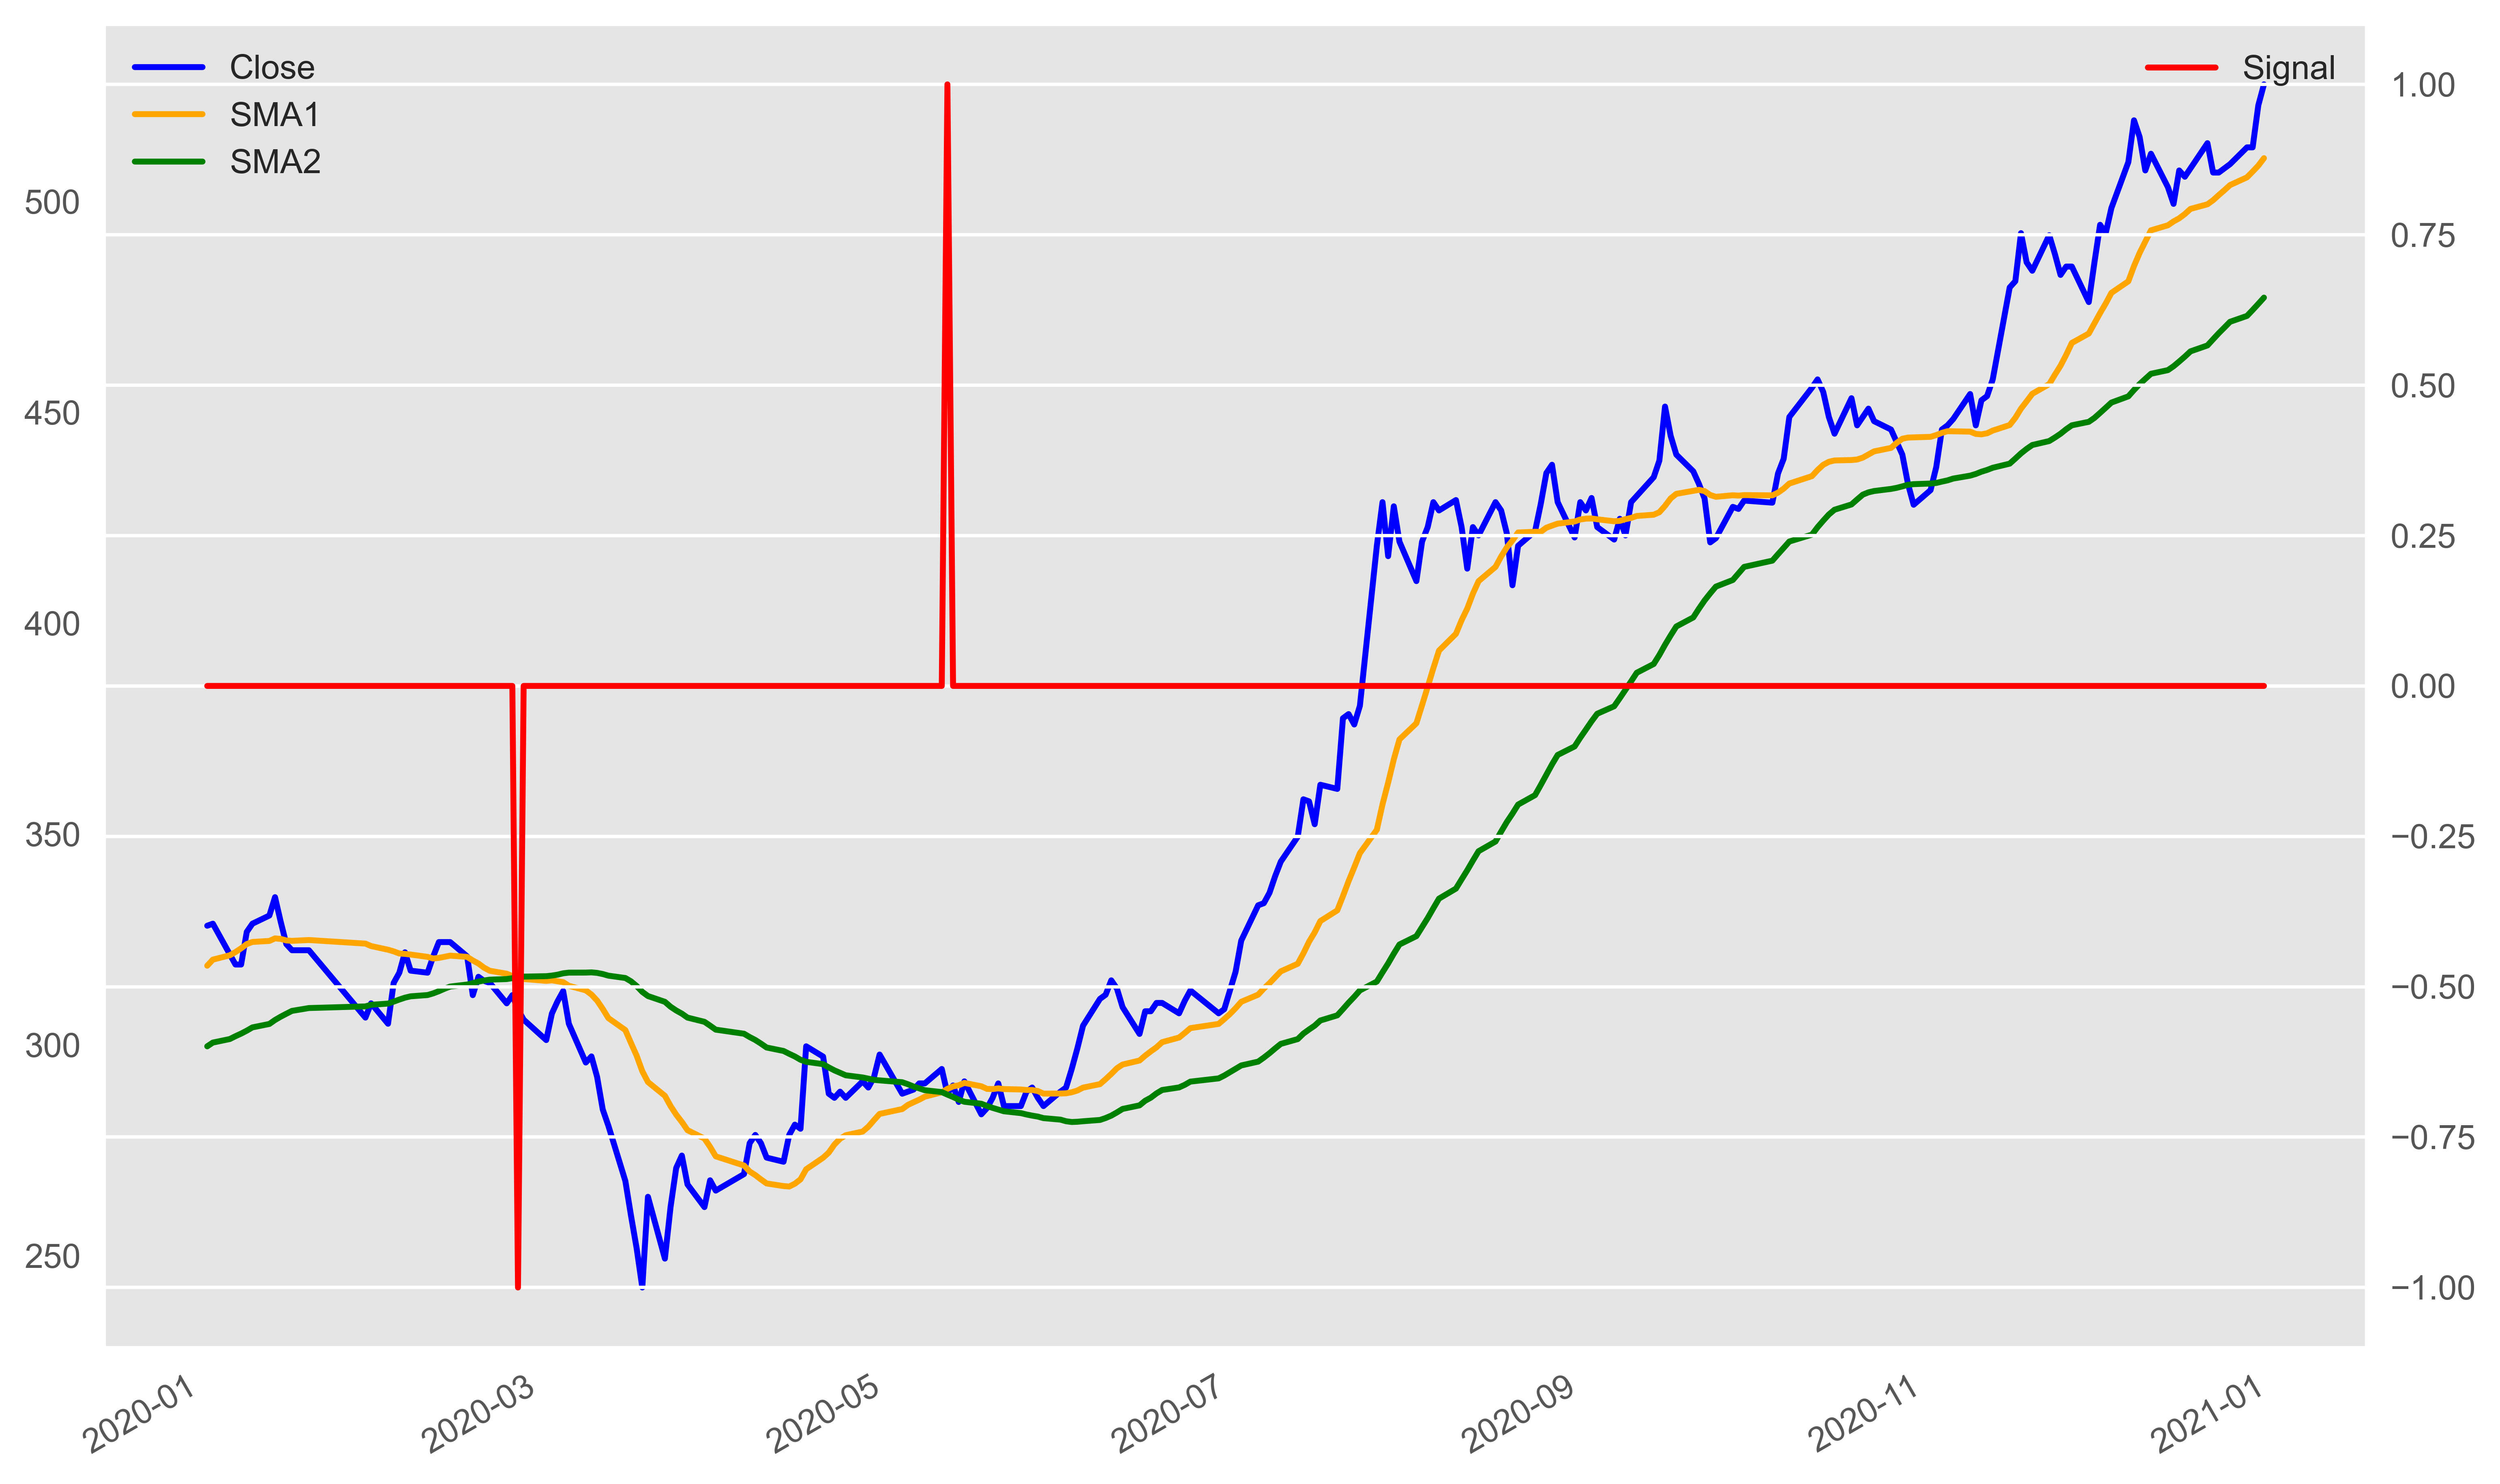

In [18]:
import talib
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('ggplot')
fig , ax = plt.subplots()
#計算SMA
sma1 = talib.SMA(df.Close, timeperiod=20)
sma2 = talib.SMA(df.Close, timeperiod=60)
# 計算買入點(黃金交叉)與賣出點(死亡交叉)
signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())
signal = signal_long.copy()
signal[signal_short] = -1
#繪圖
df.Close['2020'].plot(figsize=(12, 8), color='Blue', label='Close')
sma1['2020'].plot(figsize=(12, 8), color='Orange', label='SMA1')
sma2['2020'].plot(figsize=(12, 8), color='Green', label='SMA2')
plt.legend() 
signal['2020'].astype(int).plot(secondary_y=True, figsize=(12, 8), color='Red', label='Signal')
plt.legend() 
#signal為1時買進，而-1時賣出

In [7]:
from backtesting import Backtest, Strategy
import yfinance as yf
import pandas as pd
import talib
#取得股市資料
def get_historical_data(ticker):
  d = yf.Ticker(ticker)
  df = d.history(period="max")
  df.columns = df.columns.str.lower()
  df.columns = pd.Series(df.columns).str.capitalize().values
  return df.dropna()
df = get_historical_data('2330.TW')
#制定策略
class Strategy(Strategy):
    n1 = 20
    n2 = 60
    def init(self):
        super().init()        
        #預先計算兩條移動平均線
        close = pd.Series(self.data.Close)
        sma1 = talib.SMA(close, timeperiod=self.n1)
        sma2 = talib.SMA(close, timeperiod=self.n2)
        
        signal_long = (sma1 > sma2) & (sma1.shift() < sma2.shift())
        signal_short = (sma1 < sma2) & (sma1.shift() > sma2.shift())
        signal = signal_long
        signal[signal_short] = -1
        
        self.I(lambda x: sma1, 'sma1')
        self.I(lambda x: sma2, 'sma2')
 
        self.signal = self.I(lambda x: signal, 'signal')

    def next(self):
        super().next()
        entry_size = self.signal[-1]
        if entry_size > 0:
            self.buy()
        elif entry_size < 0:
          for trade in self.trades:
              trade.close()
bt = Backtest(df, Strategy)
result1 = bt.run()
bt.plot()
'''
最上方圖:藍色線段為報酬率，紅線為最久沒有創新高的時間段(代表投資人可能會懷疑此策略是否有效的時間)
第二張圖:正三角為做多，綠色為獲利，紅色為虧損(此交易策略為做多，所以無做空出現)
第三張圖:每一條虛線都代表一次交易，綠色代表獲利，紅色代表虧損。
第四張圖:交易量
第五張圖:為買賣訊號，signal為1時買進，而-1時賣出
'''

In [4]:
#尋找最佳均線參數
result2 = bt.optimize(n1=range(5, 200, 10),
                      n2=range(5, 200, 10))
result2._strategy

C:\Users\user\anaconda3\lib\site-packages\backtesting\backtesting.py:1472: UserWarning: Searching for best of 400 configurations.
  output = _optimize_grid()


  0%|          | 0/8 [00:00<?, ?it/s]

<Strategy Strategy(n1=125,n2=5)>